In [19]:
import os

zip_path = "archive.zip"  

if os.path.exists(zip_path):
    print("File exists:", zip_path)

    with open(zip_path, 'rb') as f:
        signature = f.read(4)
    
    print("File Signature:", signature)

    if signature.startswith(b'PK'):
        print("Valid ZIP file!")
    else:
        print("This is NOT a ZIP file. Re-download or check the format.")
else:
    print("File not found. Check the file path.")

File exists: archive.zip
File Signature: b'PK\x03\x04'
Valid ZIP file!


In [20]:
import shutil

zip_path = "archive.zip"  
extract_path = "archive" 

try:
    shutil.unpack_archive(zip_path, extract_path)
    print("Extraction successful!")
except Exception as e:
    print("Error during extraction:", e)

Extraction successful!


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


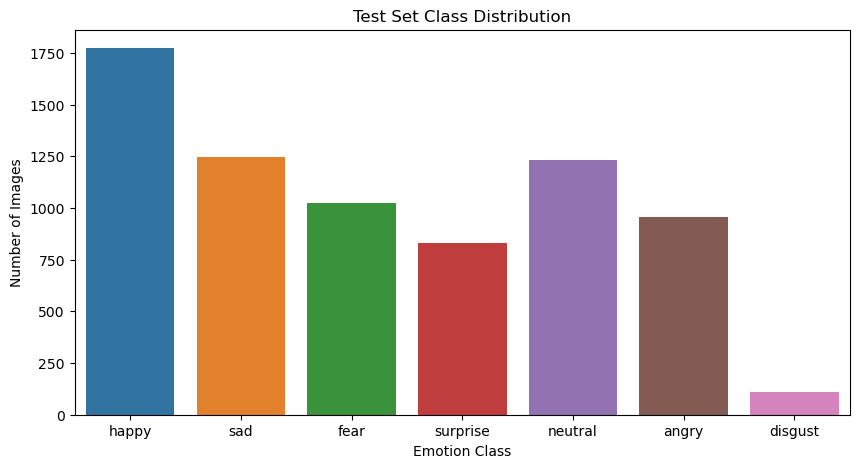

Train files: 28709, Test files: 7178


In [21]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
train_path = "archive/train"
test_path = "archive/test"

#train_files = sum([len(files) for _, _, files in os.walk(train_path)])
#test_files = sum([len(files) for _, _, files in os.walk(test_path)])
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}

# Verifying number of images per emotion class to check for imbalances on both the training and testing data

plt.figure(figsize=(10,5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Set Class Distribution")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title("Test Set Class Distribution")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.show()

train_files = sum([len(files) for _, _, files in os.walk(train_path)])
test_files = sum([len(files) for _, _, files in os.walk(test_path)])
print(f"Train files: {train_files}, Test files: {test_files}")

In [22]:
#Displaying random sample images from each class to assess noise, image quality, and variations

import cv2
import random

def plot_sample_images(directory, num_samples=5):
    classes = os.listdir(directory)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(10,10))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = random.sample(os.listdir(class_path), num_samples)

        for j, img_name in enumerate(images):
            img = cv2.imread(os.path.join(class_path, img_name))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)

    plt.tight_layout()
    plt.show()

plot_sample_images(train_dir)

In [23]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os

train_dir = "archive/train"
test_dir = "archive/test"

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2  
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset = 'validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = False
)

def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    return model

model = build_cnn_model()
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 30
)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

print(classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys()))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

model.save("emotion_detection_model.keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.2298 - loss: 2.0205 - val_accuracy: 0.2136 - val_loss: 1.9978
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.3180 - loss: 1.6921 - val_accuracy: 0.3874 - val_loss: 1.5624
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.3765 - loss: 1.5905 - val_accuracy: 0.3952 - val_loss: 1.5429
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.4021 - loss: 1.5263 - val_accuracy: 0.3066 - val_loss: 1.6814
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.4221 - loss: 1.4841 - val_accuracy: 0.4487 - val_loss: 1.4303
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.4441 - loss: 1.4533 - val_accuracy: 0.4602 - val_loss: 1.4094
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.4489 - loss: 1.4326 - val_accuracy: 0.4511 - val_loss: 1.4240
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.4542 - loss: 1.4050 - 